# Comparison of an SMPI trace with a real trace for HPL

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    df['duration'] = df['end'] - df['start']
    return df, df_links

reality_file = 'grenoble_2018-12-13_1827231.zip'
simgrid_file = '../smpi_hpl/grenoble_2018-12-13_1827440.zip'

trace_reality, link_reality = read_archive(reality_file, 'reality')
trace_simgrid, link_simgrid = read_archive(simgrid_file, 'simgrid')
traces = pandas.concat([trace_reality, trace_simgrid])

traces.head()

# Mode: reality
	BLAS trace: 1996880 lines
	MPI  trace: 3591458 lines
Removed 1997408 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 2640826 lines
	MPI  trace: 4684421 lines
Removed 16 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1,duration
0,173.488034,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,173.488,reality,1,0.000034
1,173.488296,dgemm,2.0,BLAS,125054.0,-1,2.0,0,173.488,reality,1,0.000296
2,173.489000,dtrsm,-1.0,BLAS,0.0,-1,2.0,0,173.489,reality,1,0.000000
3,173.489000,dgemm,2.0,BLAS,125052.0,-1,0.0,0,173.489,reality,1,0.000000
4,173.489002,dtrsm,-1.0,BLAS,4.0,-1,4.0,0,173.489,reality,1,0.000002


## HPL result

In [2]:
res = read_csv(reality_file, 'results.csv')
print('%s Gflops' % res['gflops'].max())
print('%s seconds' % res['time'].max())
res

4291.0 Gflops
2427.83 seconds


,proc_p,swap,gflops,proc_q,bcast,time,rfact,depth,pfact,process_per_node,residual,matrix_size,mem_align,block_size,thread_per_process
0,2,0,4291.0,4,2,2427.83,2,1,1,1,0.001305,250000,8,128,32


In [3]:
res = read_csv(simgrid_file, 'results.csv')
print('%s Gflops' % res['gflops'].max())
print('%s seconds' % res['time'].max())
res

5201.0 Gflops
2002.97 seconds


,minor_page_fault,dgemm_intercept,simulation_time,dtrsm_coefficient,time,thread_per_process,proc_q,bcast,application_time,block_size,...,swap,cpu_utilization,matrix_size,dgemm_coefficient,dtrsm_intercept,process_per_node,usr_time,depth,sys_time,pfact
0,3337905,0.000099,129.215,4.524788e-12,2002.97,32,4,2,13.9289,128,...,0,0.99,250000,2.548998e-12,0.00004,1,104.99,1,24.16,1


## Checking the parameters

In [4]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,2,4,1,2,2,1,0,8,1,32


In [5]:
read_csv(simgrid_file, 'exp_smpi.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,250000,128,2,4,1,2,2,1,0,8,1,32,2.548998e-12,0.000099,4.524788e-12,0.00004


In [6]:
print(zipfile.ZipFile(simgrid_file).read('dahu.xml').decode('ascii'))

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

In [7]:
for mode in traces['mode'].unique():
    for kind in trace_reality['kind'].unique():
        df = traces[(traces['mode'] == mode) & (traces['kind'] == kind)]
        print(mode, kind, df.start.min(), df.end.max())

reality BLAS 173.488 2600.290212
reality MPI 2.8999999999999997e-05 2843.532021
simgrid BLAS 0.09401 2003.0603449999999
simgrid MPI 0.0 2003.070829


### Removing the initialization and the finalization in the traces

In [8]:
def split(df):
    return [df[df['rank'] == rank] for rank in df['rank'].unique()]

def crop(df, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    return df[(df['start'] > start) & (df['end'] < end)]

def crop_all(df, func_name):
    df_ranks = [crop(tmp_df, func_name) for tmp_df in split(df)]
    df = pandas.concat(df_ranks)
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

In [9]:
trace_simgrid = crop_all(trace_simgrid, 'MPI_Bcast')
trace_reality = crop_all(trace_reality, 'MPI_Bcast')
traces = pandas.concat([trace_simgrid, trace_reality])

In [10]:
for mode in traces['mode'].unique():
    for kind in trace_reality['kind'].unique():
        df = traces[(traces['mode'] == mode) & (traces['kind'] == kind)]
        print(mode, kind, df.start.min(), df.end.max())

simgrid BLAS 0.0 2002.956336
simgrid MPI 0.00028100000000000347 2002.9651139999999
reality BLAS 0.0003300000000194814 2426.800542
reality MPI 0.0 2427.835838


### Zooming on the trace 

In [11]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

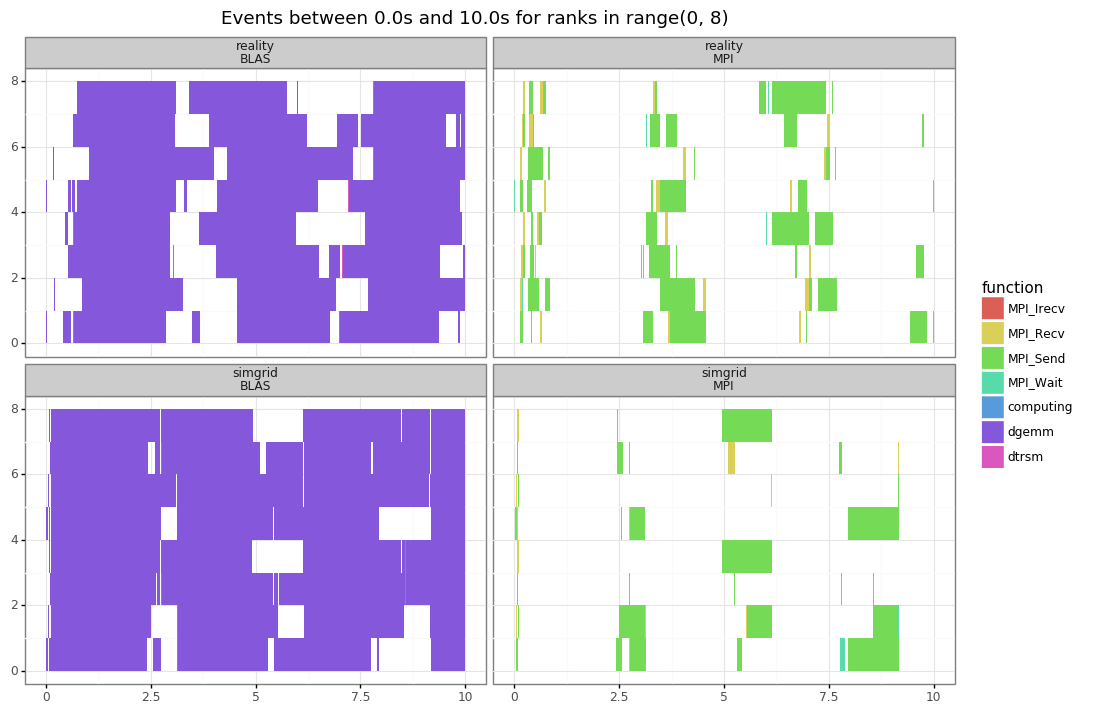

<ggplot: (-9223363308725939189)>

In [12]:
plot_bounded(traces, 0, 10, range(8))

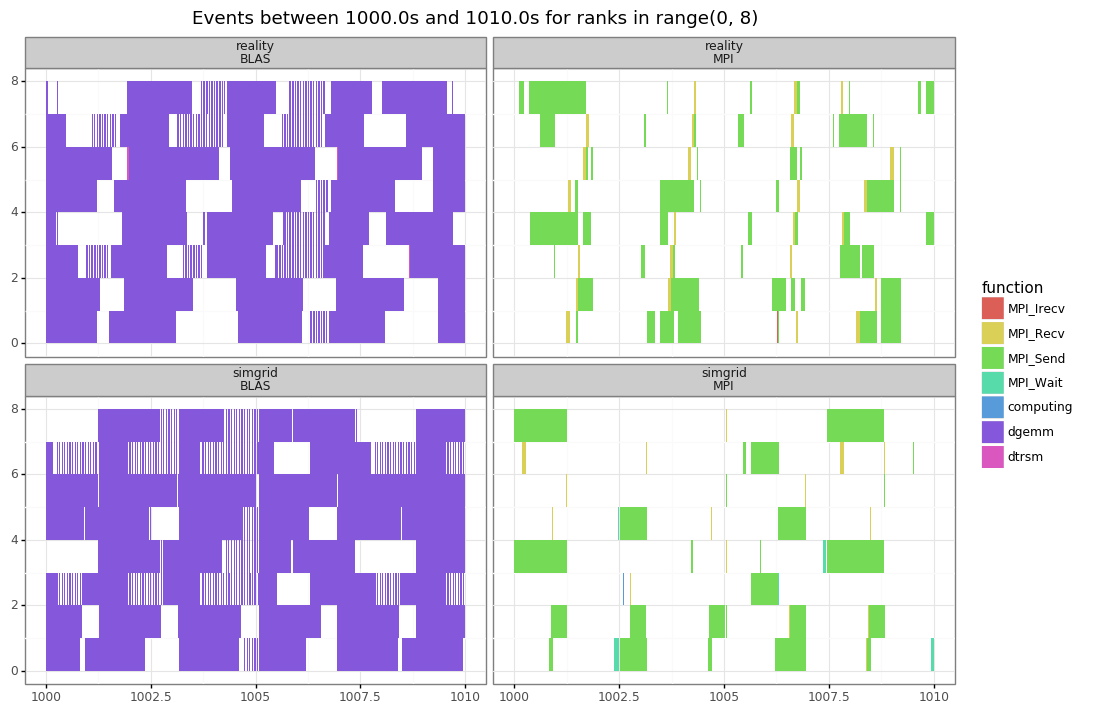

<ggplot: (-9223363308722526204)>

In [13]:
plot_bounded(traces, 1000, 1010, range(8))

## Plotting the links

In [14]:
def draw_plot(state_dataframe, link_dataframe, time_interval=None, ranks=None):
    if time_interval is None:
        time_interval = -float('inf'), float('inf')
        time_str = 'for the whole experiment'
    else:
        time_str = 'between %.1fs and %.1fs' % time_interval
    if ranks is None:
        ranks = range(0, 1000000)
        rank_str = 'for all the ranks'
    else:
        rank_str = 'for ranks in %s' % ranks
    tmp_state = state_dataframe[(state_dataframe['start'] >= time_interval[0]) & (state_dataframe['end'] <= time_interval[1]) & (state_dataframe['rank'].isin(ranks))].copy()
    tmp_state['rank+1'] = tmp_state['rank'] + 1
    tmp_link = link_dataframe[(link_dataframe['start'] >= time_interval[0]) & (link_dataframe['end'] <= time_interval[1]) & (link_dataframe['src'].isin(ranks)) & (link_dataframe['dst'].isin(ranks))]

    gc = ggplot(tmp_state) + \
        geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) +\
        theme_bw() + xlab('Time') + ylab('Rank') + theme() + ggtitle('Events %s %s' % (time_str, rank_str))
#    for i in set((tmp_state['rank'] // 32)*32):
#        if i <= 0:
#            continue
#        gc += geom_hline(yintercept=i, linetype='dashed', color='red')
    print(gc)
#    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst', color='remote'), arrow = arrow(length = 0.1))
    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst'), arrow = arrow(length = 0.1))
    print(gc)

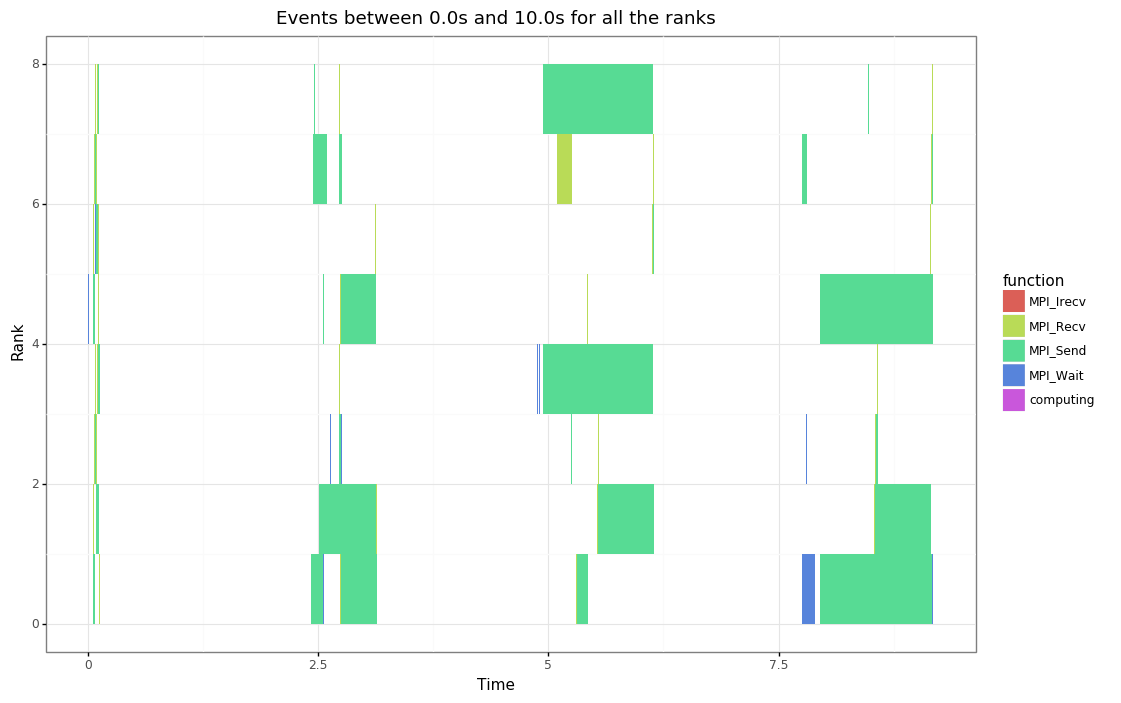

<ggplot: (8728132211702)>


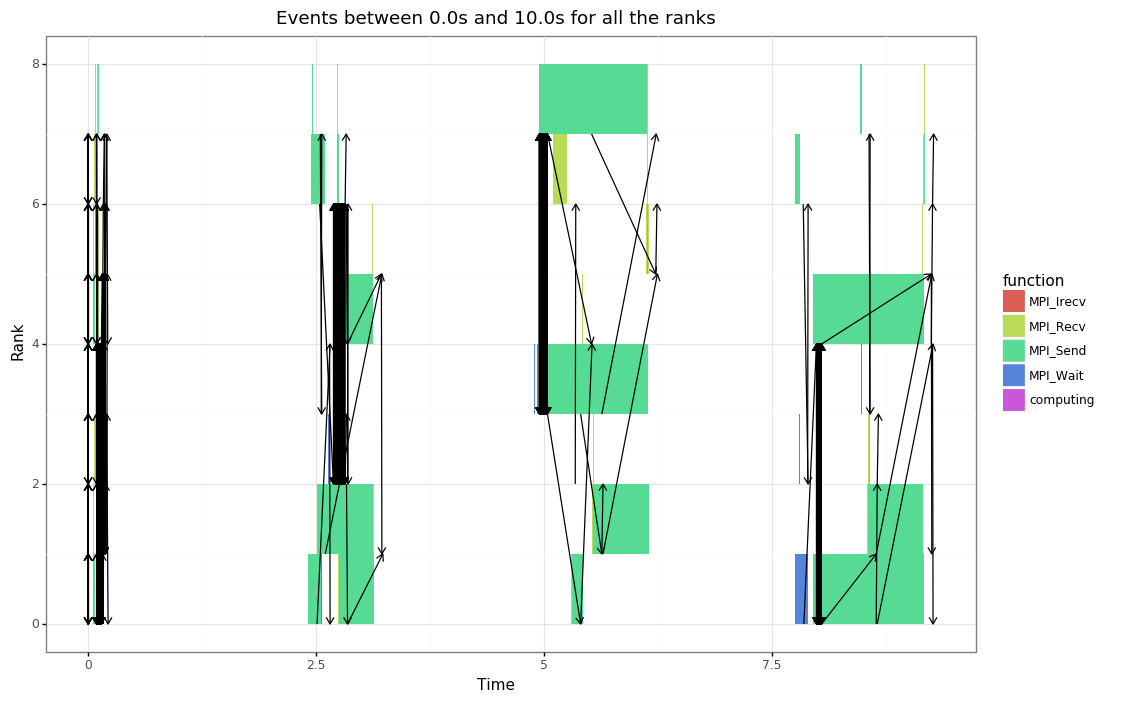

<ggplot: (8728132211702)>


In [15]:
draw_plot(trace_simgrid[trace_simgrid['kind'] == 'MPI'], link_simgrid, time_interval=(0, 10))

## Plotting the total time spent in each function

In [16]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'mode', 'start', 'end', 'duration']].copy()
    df = df.groupby(['rank', 'mode']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='mode')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    print(plot)
    df_reality = df[df['mode'] == 'reality']
    df_simgrid = df[df['mode'] == 'simgrid']
    df = df_reality.set_index('rank').join(df_simgrid.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

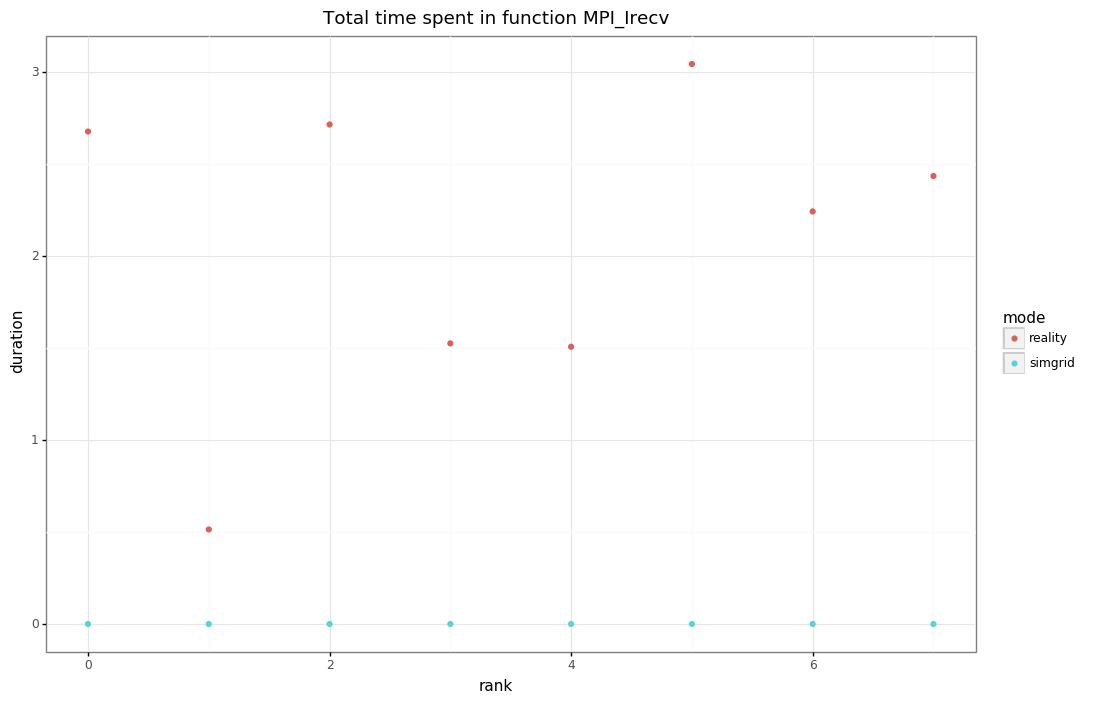

<ggplot: (-9223363308600058147)>


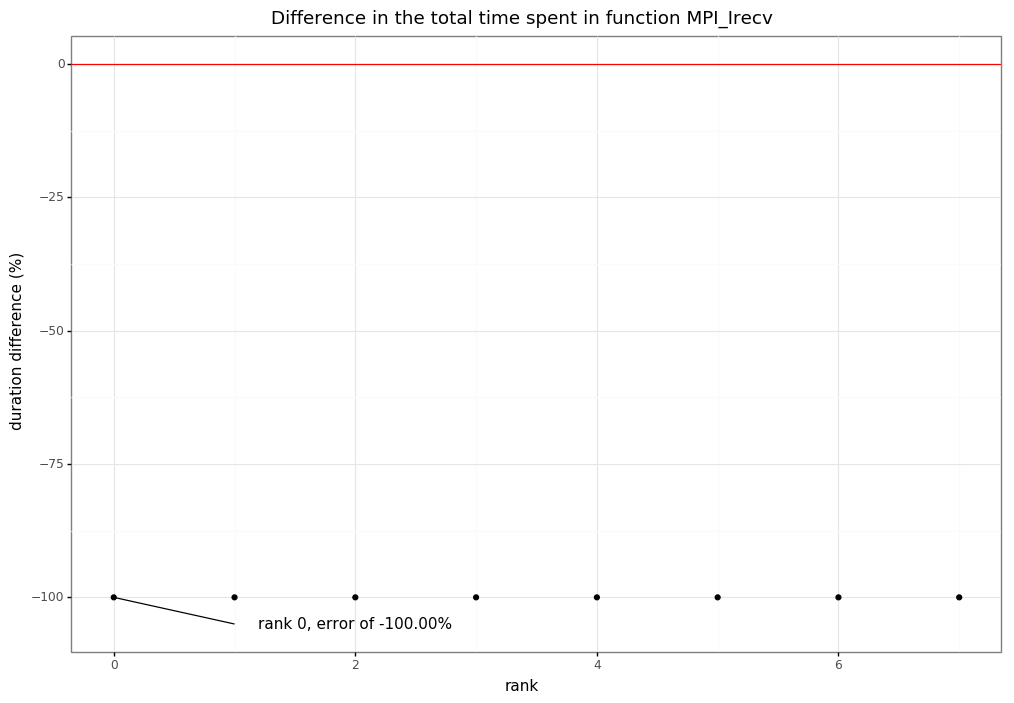

<ggplot: (8728146813139)>


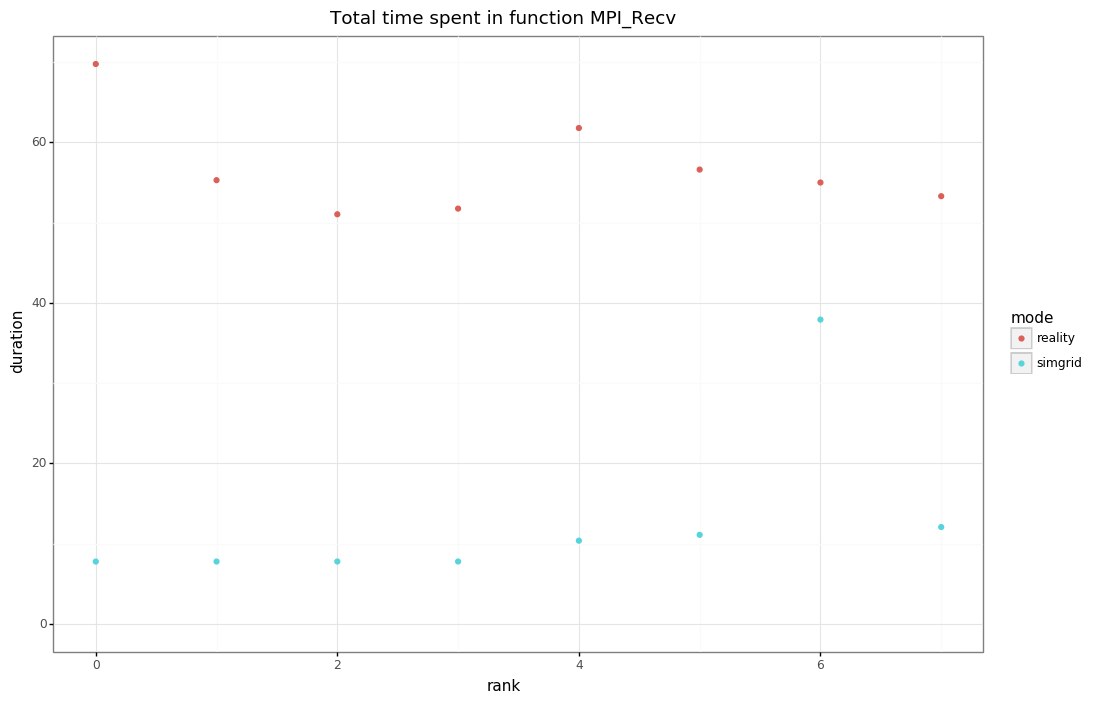

<ggplot: (-9223363308707967407)>


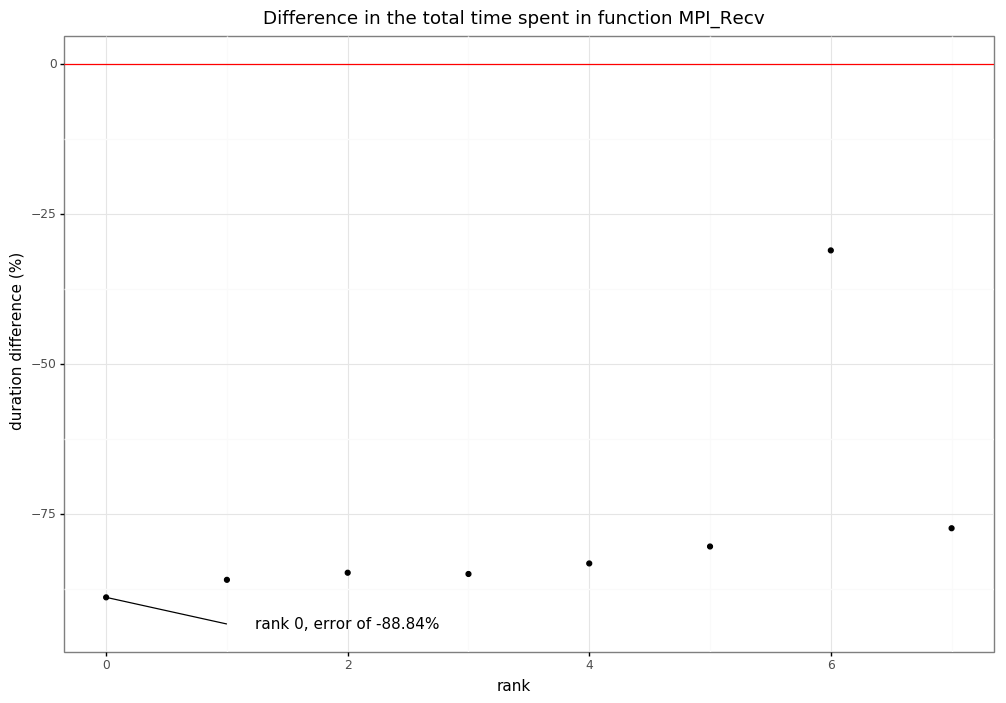

<ggplot: (-9223363308708032817)>


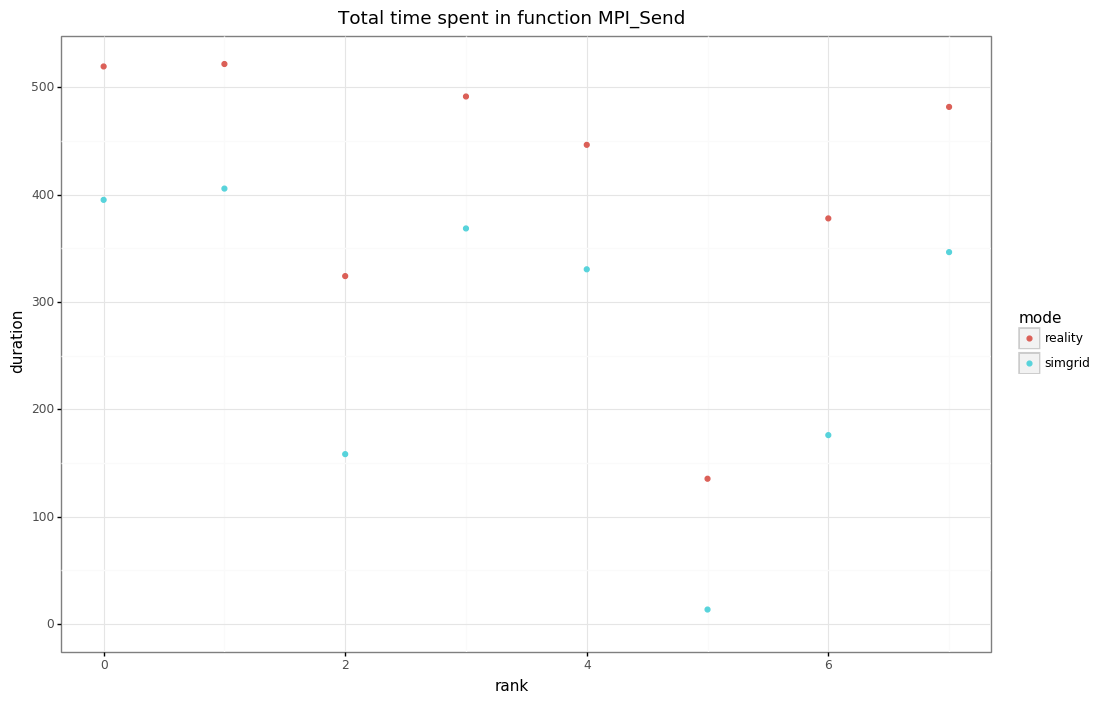

<ggplot: (8728146741638)>


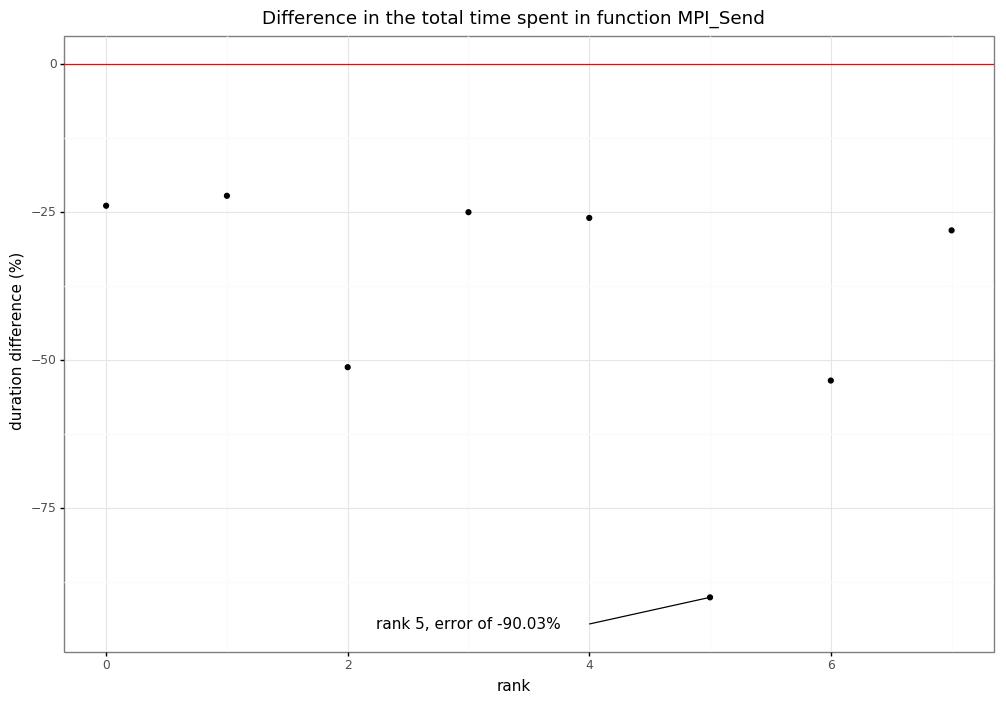

<ggplot: (-9223363308715034003)>


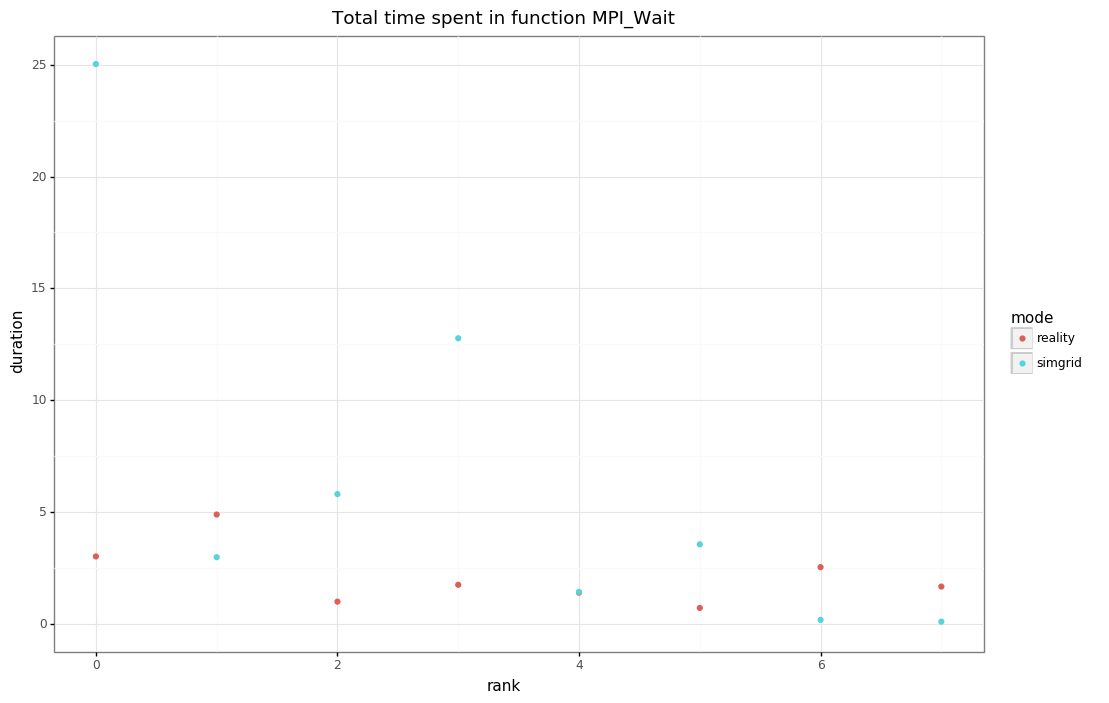

<ggplot: (-9223363308722757800)>


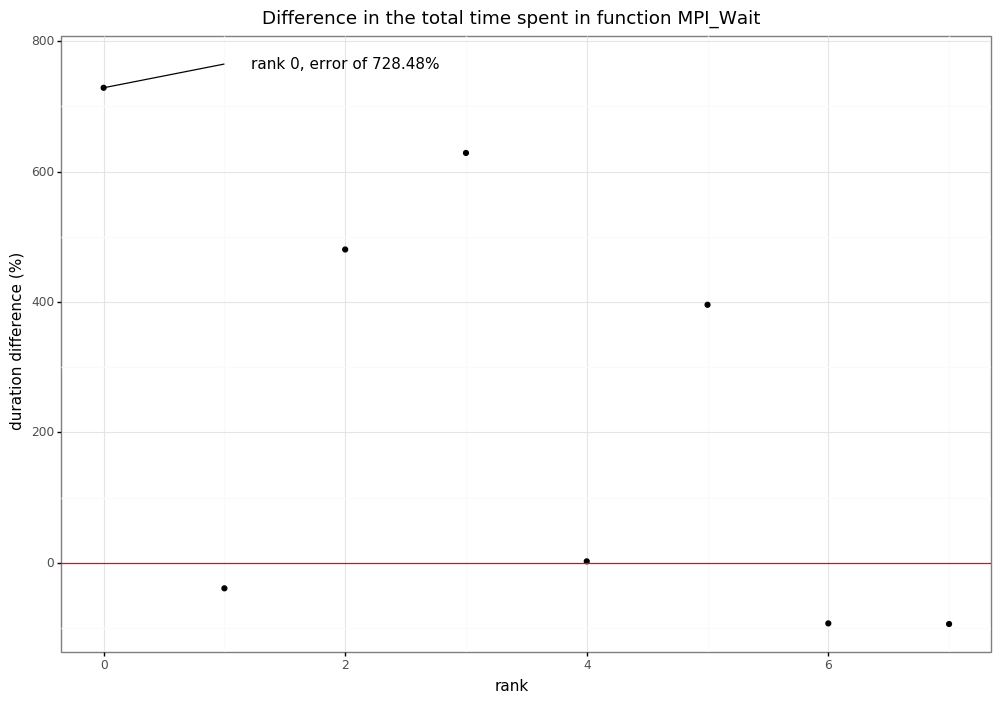

<ggplot: (-9223363308725876238)>


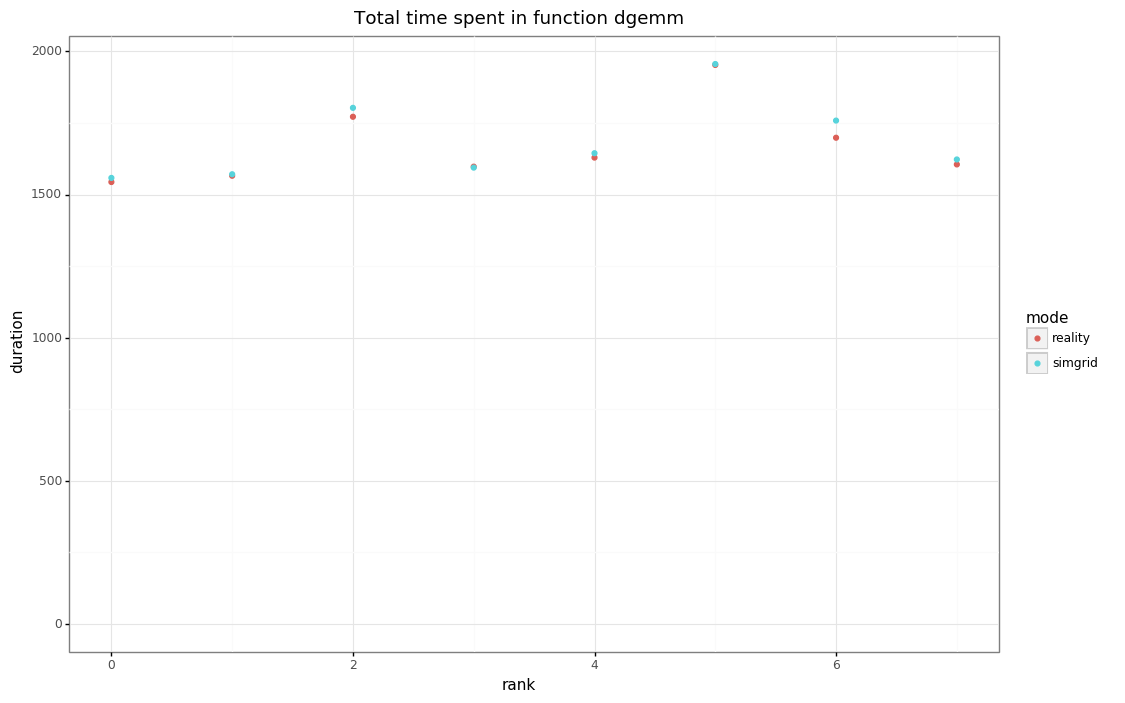

<ggplot: (-9223363308726160117)>


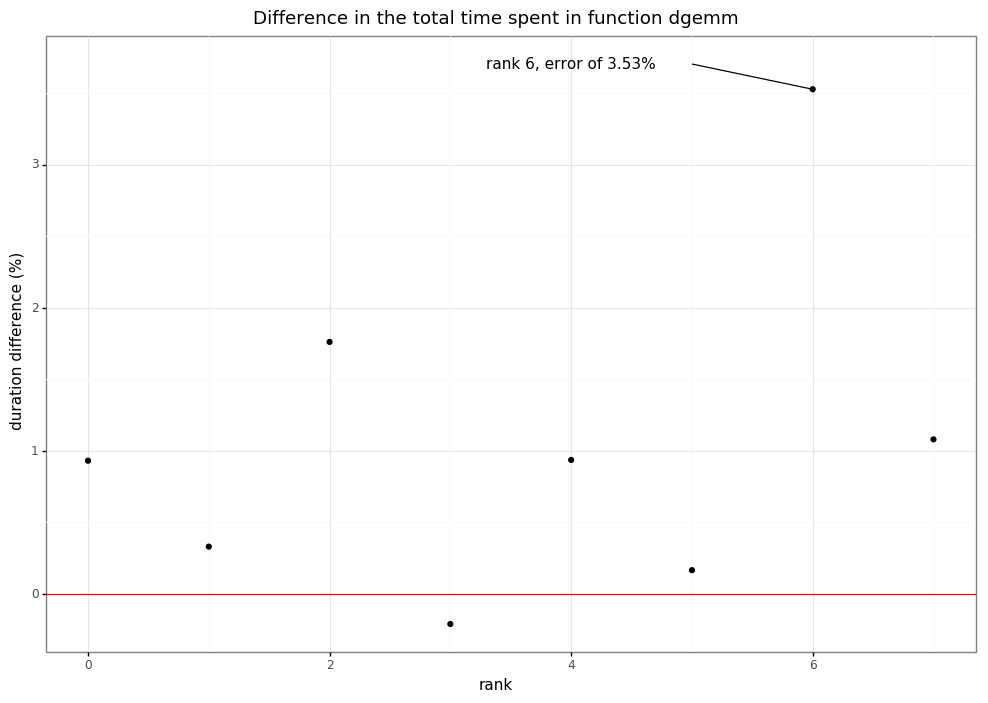

<ggplot: (8728132155414)>


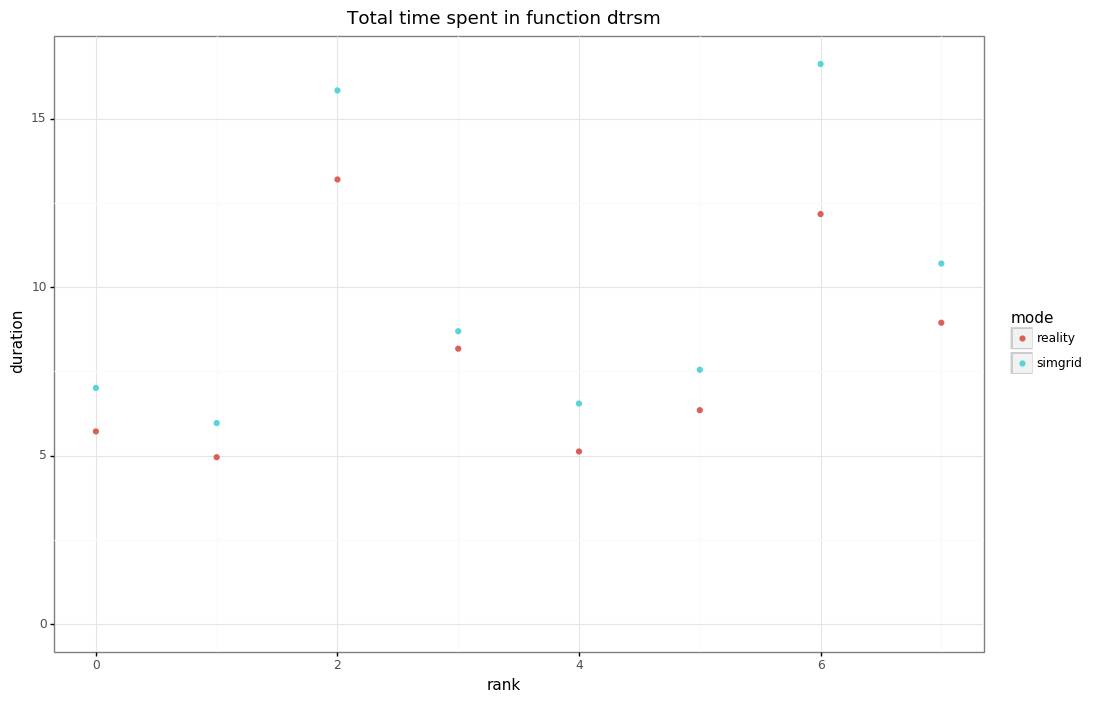

<ggplot: (-9223363308718178174)>


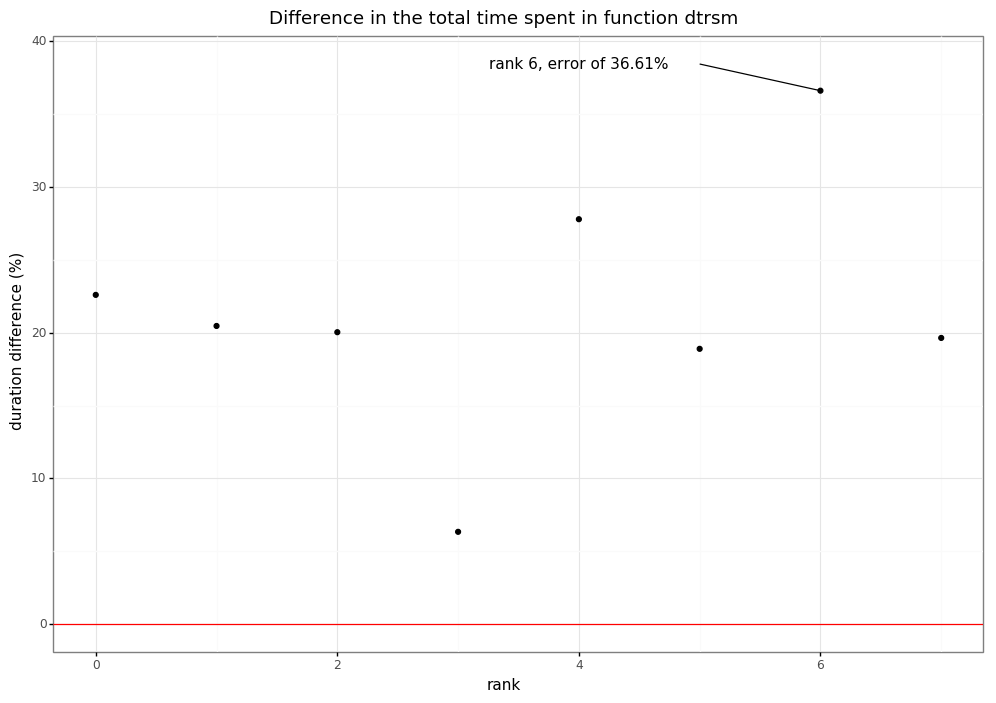

<ggplot: (-9223363308715071719)>


In [17]:
for func in sorted(set(trace_reality.function.unique()) & set(trace_simgrid.function.unique())):
    plot_total_duration(traces, func)

## Computing the average "bandwidth"

Here I divide the number of bytes sent (resp. received) by the time spent in MPI_Send (resp. MPI_Recv).
This does not make any sense for asynchronous calls, but this is roughly equal to the bandwidth for synchronous calls (neglecting the latency).

In [18]:
df = traces[traces.function.isin(['MPI_Recv', 'MPI_Send'])].copy()
df = df.groupby(['rank', 'mode', 'function']).sum().reset_index()
df_reality = df[df['mode'] == 'reality']
df_simgrid = df[df['mode'] == 'simgrid']
df = df_simgrid.set_index(['rank', 'function']).join(df_reality.set_index(['rank', 'function']), rsuffix='_reality').reset_index()
df['duration_simgrid'] = df['duration']
df['bw_simgrid'] = df['msg_size'] / df['duration_simgrid']
df['bw_reality'] = df['msg_size'] / df['duration_reality']
df[['rank', 'function', 'msg_size', 'duration_simgrid', 'duration_reality', 'bw_simgrid', 'bw_reality']]

,rank,function,msg_size,duration_simgrid,duration_reality,bw_simgrid,bw_reality
0,0,MPI_Recv,93899396680,7.782115,69.759436,1.206605e+10,1.346046e+09
1,0,MPI_Send,125616157576,395.271016,519.576278,3.177975e+08,2.417665e+08
2,1,MPI_Recv,93899526728,7.782190,55.287875,1.206595e+10,1.698375e+09
3,1,MPI_Send,125503844816,405.772704,521.853167,3.092959e+08,2.404965e+08
4,2,MPI_Recv,93963491920,7.787436,51.041455,1.206604e+10,1.840925e+09
5,2,MPI_Send,125487333240,158.298056,324.223773,7.927282e+08,3.870393e+08
6,3,MPI_Recv,93963491920,7.787437,51.749964,1.206604e+10,1.815721e+09
7,3,MPI_Send,125487199424,368.627580,491.588943,3.404173e+08,2.552686e+08
8,4,MPI_Recv,125073430088,10.381843,61.785197,1.204732e+10,2.024327e+09
9,4,MPI_Send,125331711440,330.539243,446.548004,3.791735e+08,2.806679e+08


In [19]:
df[['function', 'bw_simgrid', 'bw_reality']].groupby('function').mean()

,bw_simgrid,bw_reality
function,,
MPI_Recv,1.065397e+10,1.944798e+09
MPI_Send,1.559532e+09,3.649976e+08


We see here that the "average bandwidth" is about 10 GB/s in Simgrid and less than 500MB/s in reality. The Omnipath links that we have should be 100Gb/s (12.5 GB/s). So maybe we have a problem in reality? Maybe we don't use the right network interface?

In [20]:
matrix_size = read_csv(reality_file, 'exp.csv').matrix_size.unique()[0]
print(matrix_size)

250000


In [21]:
print(matrix_size ** 2 * 8)
print(df[df.function == 'MPI_Recv'].msg_size.sum())
print(df[df.function == 'MPI_Send'].msg_size.sum())

500000000000
876165004768
1002797603008


I just checked above if the amount of data sent/received is "normal". For the whole execution, we expect it to be of the same order of magnitude as the memory occupation of the matrix (we did only 5 iterations here).

## Counting the number of events

In [22]:
traces[['function', 'mode', 'rank']].groupby(['function', 'mode']).count()

rank
function  mode            
MPI_Irecv reality   519512
          simgrid   509752
MPI_Recv  reality    17584
          simgrid    16605
MPI_Send  reality   537096
          simgrid   526357
MPI_Wait  reality   519512
          simgrid   509752
computing simgrid  3121574
dgemm     reality   998434
          simgrid  1320367
dtrsm     reality   998434
          simgrid  1320367

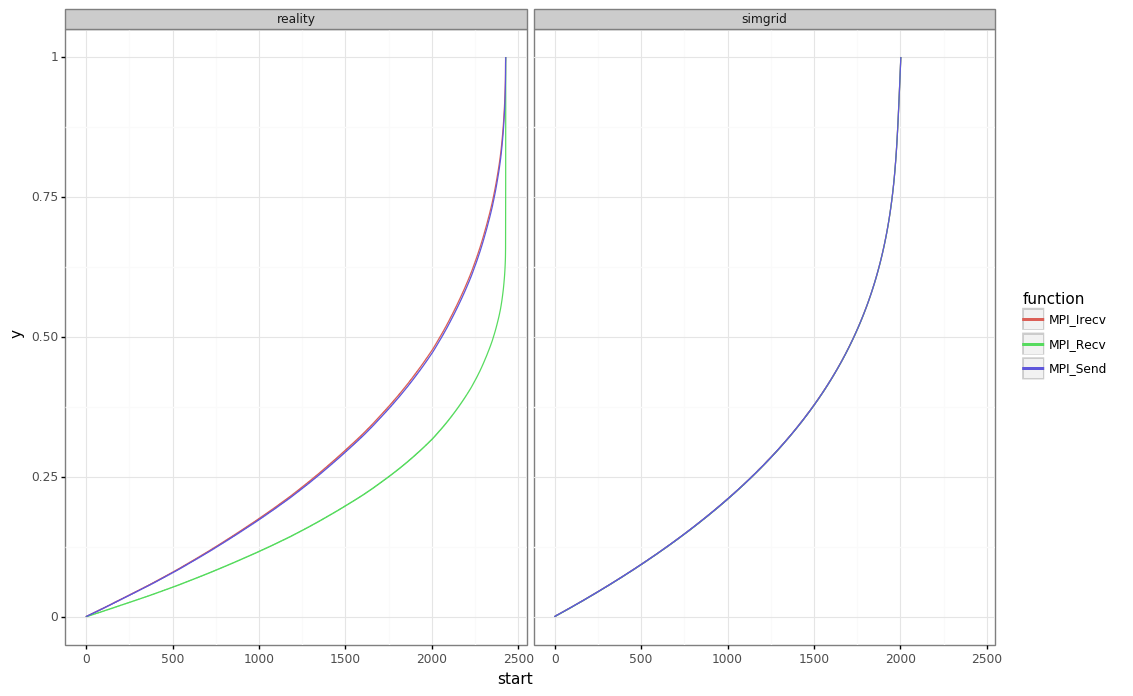

<ggplot: (8728140603042)>

In [23]:
ggplot(traces[traces.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

## Comparing the communications

In [24]:
traces[traces['function'].isin(['MPI_Send', 'MPI_Recv', 'MPI_Irecv'])].groupby(['function', 'mode']).sum()[['msg_size', 'duration']]

msg_size     duration
function  mode                               
MPI_Irecv reality   375126070296    16.670241
          simgrid   126632598240     0.000000
MPI_Recv  reality   751172025952   454.528549
          simgrid   876165004768   102.634147
MPI_Send  reality  1126298096248  3299.037315
          simgrid  1002797603008  2194.591108

In [25]:
traces[traces['function'].isin(['MPI_Send', 'MPI_Recv', 'MPI_Irecv'])].groupby(['function', 'rank', 'mode']).sum()[['msg_size', 'duration']]

msg_size    duration
function  rank mode                             
MPI_Irecv 0    reality   46843079584    2.678790
               simgrid   31344070656    0.000000
          1    reality   46772811976    0.514167
               simgrid   31296967168    0.000000
          2    reality   46747143808    2.716745
               simgrid   31279972352    0.000000
          3    reality   46843192856    1.526158
               simgrid   31343935488    0.000000
          4    reality   47069798344    1.507971
               simgrid     374562232    0.000000
          5    reality   46903048064    3.045799
               simgrid     309464832    0.000000
          6    reality   46973622000    2.244055
               simgrid     373796272    0.000000
          7    reality   46973373664    2.436556
               simgrid     309829240    0.000000
MPI_Recv  0    reality   93900397128   69.759436
               simgrid   93899396680    7.782115
          1    reality   93900526280   55.287875
               simgrid   93899526728    7.782190
          2    reality   93964491344   51.041455
               simgrid   93963491920    7.787436
          3    reality   93964491344   51.749964
               simgrid   93963491920    7.787437
          4    reality   93796457032   61.785197
               simgrid  125073430088   10.381843
          5    reality   93860564424   56.611862
               simgrid  125090584008   11.111432
          6    reality   93860567632   54.998208
               simgrid  125073578576   37.921672
          7    reality   93924530768   53.294552
               simgrid  125201504848   12.080022
MPI_Send  0    reality  141034420632  519.576278
               simgrid  125616157576  395.271016
          1    reality  140867410512  521.853167
               simgrid  125503844816  405.772704
          2    reality  140874148024  324.223773
               simgrid  125487333240  158.298056
          3    reality  140873769768  491.588943
               simgrid  125487199424  368.627580
          4    reality  140831719792  446.548004
               simgrid  125331711440  330.539243
          5    reality  140569270424  135.390115
               simgrid  125092426064   13.502121
          6    reality  140671671368  377.982648
               simgrid  125203501512  176.024870
          7    reality  140575685728  481.874387
               simgrid  125075428936  346.555518

In [26]:
def compute_cumsum(df, column, functions):
    dataframes = []
    for mode in df['mode'].unique():
        for function in functions:
            cols = ['start', 'end', 'function', 'mode'] + [column]
            tmp = df[(df['mode'] == mode) & (df['function'] == function)][cols].copy()
            tmp = tmp.sort_values(by=['start'])
            tmp['cumsum'] = tmp[column].cumsum()
            dataframes.append(tmp)
    return pandas.concat(dataframes)

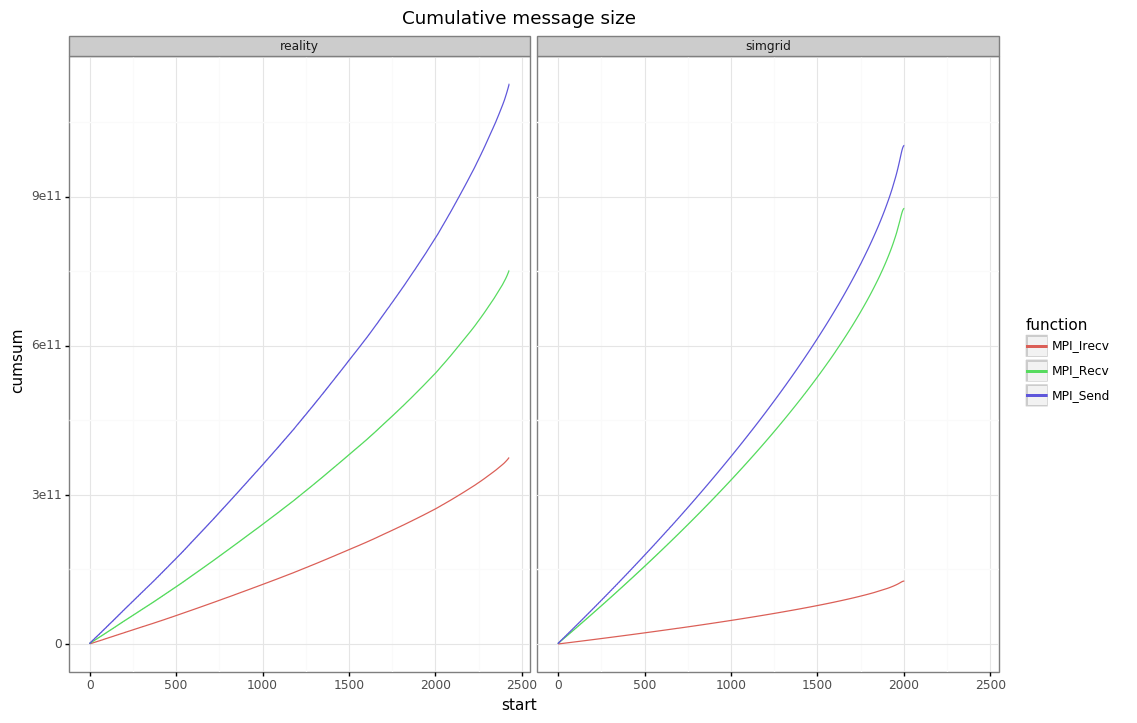

<ggplot: (-9223363308734692846)>

In [27]:
plot = ggplot(compute_cumsum(traces, 'msg_size', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative message size')

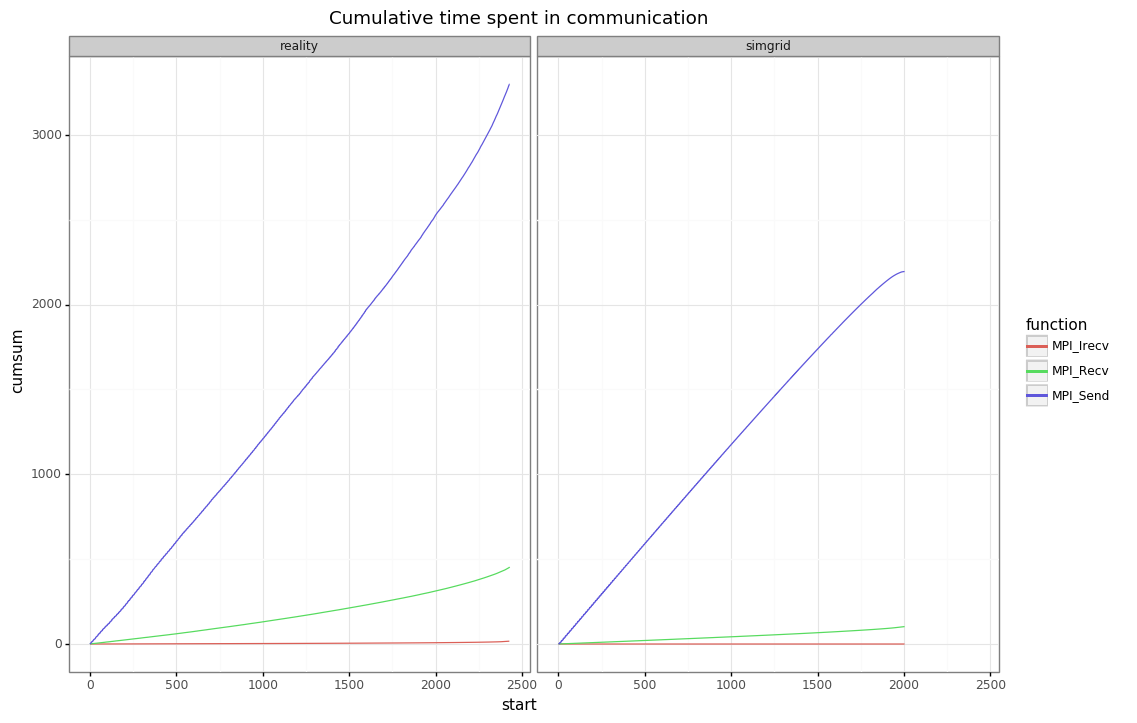

<ggplot: (-9223363308745379205)>

In [28]:
plot = ggplot(compute_cumsum(traces, 'duration', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in communication')

## Comparing the computations

In [29]:
tmp = traces[traces['kind'] == 'BLAS'].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2

In [30]:
tmp.groupby(['function', 'mode']).sum()[['size_product', 'duration']]

size_product      duration
function mode                               
dgemm    reality  5.206334e+15  13363.748798
         simgrid  5.206334e+15  13506.919887
dtrsm    reality  7.997333e+12     64.609219
         simgrid  7.997333e+12     78.906796

In [31]:
tmp.groupby(['function', 'rank', 'mode']).sum()[['size_product', 'duration']]

size_product     duration
function rank mode                              
dgemm    0    reality  6.516625e+14  1543.712947
              simgrid  6.516625e+14  1558.092767
         1    reality  6.504285e+14  1565.686721
              simgrid  6.504285e+14  1570.872651
         2    reality  6.506631e+14  1771.659824
              simgrid  6.506631e+14  1802.860736
         3    reality  6.511623e+14  1597.393918
              simgrid  6.511623e+14  1594.053315
         4    reality  6.512870e+14  1629.042200
              simgrid  6.512870e+14  1644.302549
         5    reality  6.500545e+14  1952.639491
              simgrid  6.500545e+14  1955.901832
         6    reality  6.502884e+14  1698.429131
              simgrid  6.502884e+14  1758.309972
         7    reality  6.507877e+14  1605.184566
              simgrid  6.507877e+14  1622.526065
dtrsm    0    reality  1.001066e+12     5.716554
              simgrid  1.001066e+12     7.008218
         1    reality  9.985394e+11     4.950371
              simgrid  9.985391e+11     5.963286
         2    reality  9.990189e+11    13.194031
              simgrid  9.990189e+11    15.837131
         3    reality  1.000042e+12     8.171883
              simgrid  1.000042e+12     8.689082
         4    reality  1.001066e+12     5.120743
              simgrid  1.001066e+12     6.543757
         5    reality  9.985394e+11     6.346669
              simgrid  9.985391e+11     7.545670
         6    reality  9.990189e+11    12.166174
              simgrid  9.990189e+11    16.620556
         7    reality  1.000042e+12     8.942794
              simgrid  1.000042e+12    10.699096

In [32]:
print(len(tmp))
tmp = tmp[tmp['size_product'] > 0]
print(len(tmp))

4637602
2966747


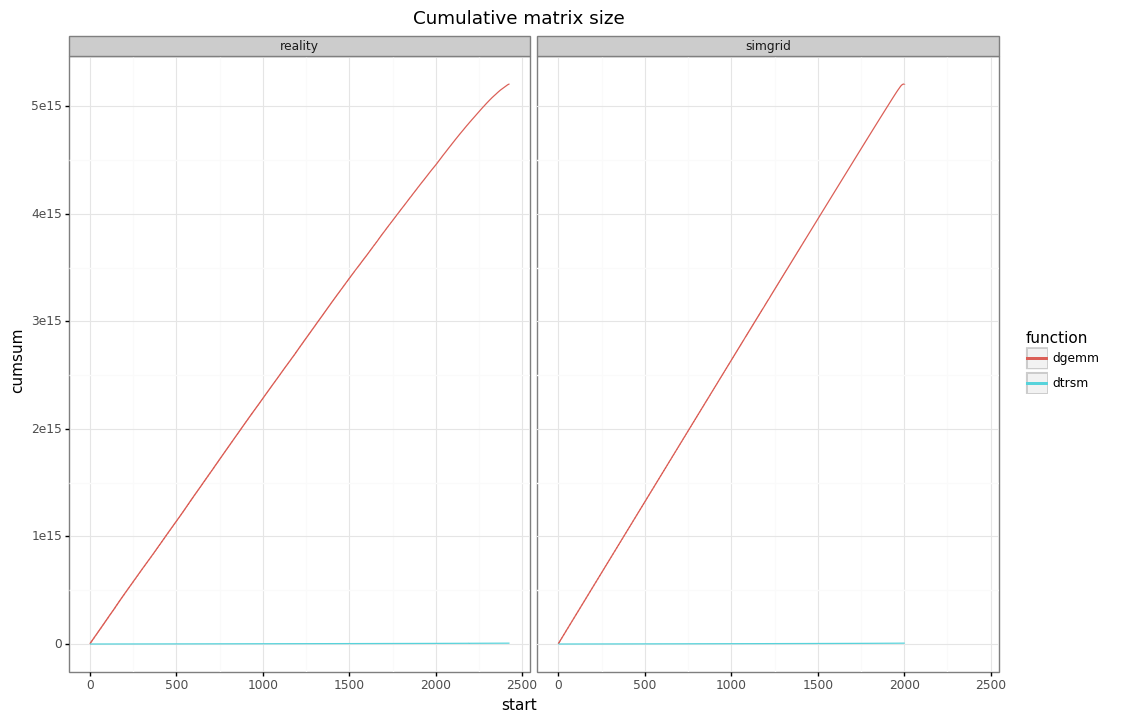

<ggplot: (8728254715996)>

In [33]:
plot = ggplot(compute_cumsum(tmp, 'size_product', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative matrix size')

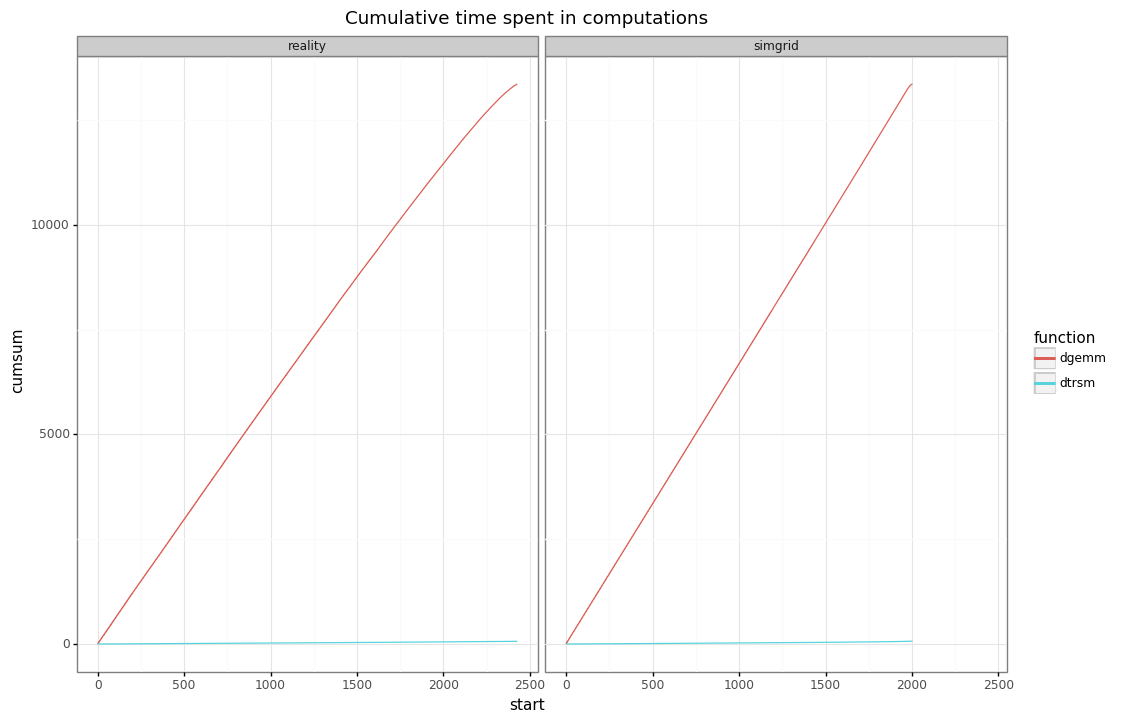

<ggplot: (8728146745471)>

In [34]:
plot = ggplot(compute_cumsum(tmp, 'duration', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in computations')